In [56]:
import os
import random
import sys
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for statistics
from scipy.stats import kstest

# preprocessing
from sklearn.preprocessing import StandardScaler

# ml methods
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

def seed_everything(seed):
    # фискирует максимум сидов для корректности сравнения разных экспериментов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
SEED = 42
seed_everything(SEED)

# Datasets

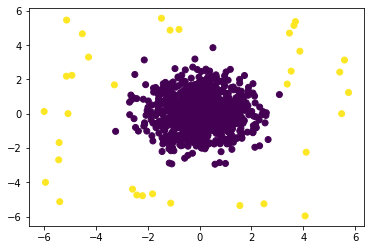

In [57]:
# Синтетически сгенерированные нормально распределенные данные
data_norm = pd.DataFrame(data=np.random.normal(
                        loc=0, scale=1, size=(1000, 2)), 
                       columns=['x', 'y'])
data_noise = pd.DataFrame(data=np.random.uniform(
                        low=-6, high=6, size=(int(data_norm.shape[0]*.05), data_norm.shape[1])), 
                        columns=['x', 'y'])
filter = (
    (data_noise['x'] < data_norm['x'].min())
    | (data_noise['x'] > data_norm['x'].max())
    | (data_noise['y'] < data_norm['y'].min())
    | (data_noise['y'] > data_norm['y'].max())
    )
data_noise = data_noise[filter]
data_norm['anomaly'] = 0
data_noise['anomaly'] = 1

df_norm = pd.concat((data_norm, data_noise))
plt.scatter(df_norm['x'], df_norm['y'], c=df_norm['anomaly'])
plt.show()

In [58]:
# SKAB data

from google.colab import drive
drive.mount('/content/drive')
! cp -r /content/drive/MyDrive/Study/MIPT_magistery/qualification_work/data .


all_files=[]
for root, dirs, files in os.walk("data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# формируем датафрейм
dfs=[]
for path in all_files:
    df = pd.read_csv(path,index_col='datetime',sep=';',parse_dates=True)
    print(path, df.shape)
    dfs.append(df)
print('Features:')
for col in dfs[2].columns:
    print('\t',col)
dfs = [df for df in dfs if df.shape[1] == 10]
df_skab = pd.concat(dfs)
print(df_skab.shape)
df_skab = df_skab.drop_duplicates()
df_skab = df_skab.drop('changepoint', axis=1)
display(df_skab)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data/valve2/0.csv (1125, 10)
data/valve2/3.csv (995, 10)
data/valve2/2.csv (1129, 10)
data/valve2/1.csv (1063, 10)
data/other/7.csv (1090, 10)
data/other/9.csv (1144, 10)
data/other/13.csv (923, 10)
data/other/4.csv (1191, 10)
data/other/12.csv (1048, 10)
data/other/5.csv (1155, 10)
data/other/3.csv (1137, 10)
data/other/14.csv (905, 10)
data/other/11.csv (1190, 10)
data/other/10.csv (1327, 10)
data/other/8.csv (1147, 10)
data/other/6.csv (1147, 10)
data/other/2.csv (780, 10)
data/other/1.csv (745, 10)
data/valve1/7.csv (1094, 10)
data/valve1/9.csv (1148, 10)
data/valve1/13.csv (1140, 10)
data/valve1/4.csv (1095, 10)
data/valve1/12.csv (1140, 10)
data/valve1/5.csv (1154, 10)
data/valve1/15.csv (1150, 10)
data/valve1/0.csv (1147, 10)
data/valve1/3.csv (1148, 10)
data/valve1/14.csv (1139, 10)
data/valve1/11.csv (1141, 10)
data/valve1/10.csv (1146, 10)
data/valv

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly
datetime,,,,,,,,,
2020-03-09 15:56:30,0.027608,0.039203,1.290480,0.054711,68.6194,24.3670,241.062,32.0362,0.0
2020-03-09 15:56:31,0.027166,0.039940,1.285650,0.382638,68.5923,24.3660,238.709,32.9649,0.0
2020-03-09 15:56:32,0.027718,0.040167,1.155880,0.054711,68.5207,24.3666,226.485,32.0362,0.0
2020-03-09 15:56:33,0.028045,0.038026,0.971268,0.382638,68.5425,24.3634,220.378,32.9649,0.0
2020-03-09 15:56:34,0.027644,0.038580,1.072460,-0.273216,68.6569,24.3639,233.922,32.0000,0.0
...,...,...,...,...,...,...,...,...,...
2020-03-09 10:54:29,0.026662,0.040014,1.267370,0.054711,72.7882,25.6189,236.598,31.0010,0.0
2020-03-09 10:54:30,0.027449,0.039046,1.283910,0.054711,72.7927,25.6224,223.683,32.0000,0.0
2020-03-09 10:54:31,0.026338,0.039350,1.138820,0.054711,72.7045,25.6224,236.186,31.9990,0.0


In [59]:
datasets = [df_norm, df_skab]

# Статический метод выявления выбросов (3 сигма)

In [60]:
def check_kstest(df, alpha=0.05):
    columns = list(df.columns)
    cols_with_pos_res = []
    for col in columns:
        if kstest(df[col], 'norm').pvalue > alpha:
            cols_with_pos_res.append(col)
    return cols_with_pos_res

def outliers_z_score(data, feature):
    x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print(f'Признак {feature}. Число выбросов по методу z-отклонения: {outliers.shape[0]}')
    return outliers

def z_score_method(df):
    """
    Метод работает с нормально распределенными данными,
    при чем с небольшим (до 10%) количеством выбросов.
    С ненормально распределенными данными не работает.
    """
    norm_cols = check_kstest(df)
    if norm_cols:
        outliers = pd.DataFrame()
        for col in norm_cols:
            outliers = pd.concat((outliers, outliers_z_score(df, col)))
        outliers = outliers.drop_duplicates()
        outliers['anomaly_preds'] = 1
        df_with_marked_outliers = df.merge(outliers, how='outer').fillna(0)
        return outliers, df_with_marked_outliers
    else:
        print('The data are not normally distributed')
        return None, df

# Метрики

In [61]:
# f1_score
def score_metrics(real_outliers, pred_outliers):
    scores = {}
    # scores['f1_score'] = f1_score(real_outliers, pred_outliers)
    scores = classification_report(real_outliers, pred_outliers)
    return scores

Ищем выбросы

In [75]:
def stat_method(X, y):
    outliers, X = z_score_method(X)
    if outliers is not None:
        print(score_metrics(y, X['anomaly_preds']))

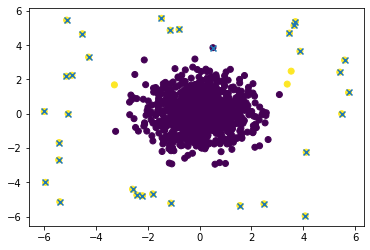

In [63]:
plt.scatter(df_norm['x'], df_norm['y'], c=df_norm['anomaly'])
plt.scatter(outliers['x'], outliers['y'], marker='x')
plt.show()

In [64]:
outliers, df_skab = z_score_method(df_skab)

The data are not normally distributed


# ML методы

In [65]:
def preprocessing(df):
    X = df.copy()
    y = X.pop('anomaly')

    # preprocessing
    columns = list(X.columns)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(data=X, columns=columns)
    return X, y

def ml_method(X, y, model, params):
    grid = GridSearchCV(
                estimator=model(),
                param_grid=params,
                scoring='f1_micro',
                return_train_score=True).fit(X, y)
    pred = grid.best_estimator_.predict(X)
    pred[pred == 1] = 0
    pred[pred == -1] = 1
    print(grid.best_estimator_)
    print(score_metrics(y, pred))

In [66]:
ml_models = {}
ml_models['IsolationForest'] = {
    'model': IsolationForest,
    'params': {
        'n_estimators': [50, 100, 500],
        'bootstrap': [True, False],
        }
    }
ml_models['OneClassSVM'] = {
    'model': OneClassSVM,
    'params': {
        'nu': [0.001, 0.01, 0.1, 0.5, 1],
    }
}

In [77]:
for df in datasets:
    X, y = preprocessing(df)
    stat_method(X, y)
    for model in ml_models:
        ml_method(X, y, ml_models[model]['model'], 
                        ml_models[model]['params'])

The data are not normally distributed


KeyboardInterrupt: ignored

In [55]:
# print('df_skab')
# X, y = preprocessing(df_skab)
# # ml_method(X, y, models['IsolationForest']['model'], 
# #                 models['IsolationForest']['params'])
# ml_method(X, y, models['OneClassSVM']['model'], 
#                 models['OneClassSVM']['params'])